# LDA Topic Modeling

This notebook implements topic modeling using gensim LDA

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaModel, LdaMulticore
pd.set_option('display.width',-1)


In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load Data

In [3]:
df = pd.read_csv('../data/all_data.csv')
df.head()

,reviews,rating,company
0,Great card! We get cash back for our grocery a...,4.0,American Express Blue Cash Preferred
1,While traveling we had to keep calling the Cre...,1.0,Credit One Bank
2,Great card to have! Love all the additional cr...,5.0,Capital One Quicksilver Rewards
3,no tengo tanta experiencia asi que no puedo da...,2.0,Citi Double Cash Card
4,This is a basic credit card. The cash back dea...,4.0,Bank of America Cash Rewards Credit Card


In [4]:
df.shape

(25708, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25708 entries, 0 to 25707
Data columns (total 3 columns):
reviews    25708 non-null object
rating     25708 non-null float64
company    25708 non-null object
dtypes: float64(1), object(2)
memory usage: 602.7+ KB


In [6]:
# Drop rows with missing value if any
df = df.dropna().reset_index(drop = True)

In [7]:
# Remove wide space in review texts
df['reviews']  = df['reviews'].apply(detokenizer)
df.to_csv('../data/all_data.csv', index = False) # save as csv file

In [8]:
#Display the index row
print_review(df, index =25247)

Review: Great experience with American Express. Their customer service is outstanding, and they are invariably pleasant to deal with - including a next-day ship on a misplaced card. The cashback is another great feature!
Rating: 5.0
Credit card: American Express Blue Cash Preferred 


In [9]:
# reload the data
df =pd.read_csv('../data/all_data.csv') 

In [10]:
review_count = df.groupby('company')['reviews'].count().sort_values(ascending = False)
review_count.head()

company
Bank of America Cash Rewards Credit Card    2476
Capital One Quicksilver Rewards             2292
Capital One Venture Rewards                 2204
Capital One Platinum                        2103
Credit One Bank                             2016
Name: reviews, dtype: int64

In [11]:
len(review_count)

40

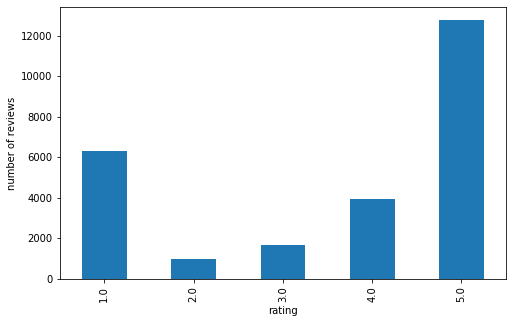

In [12]:
df.groupby('rating')['reviews'].count().plot(kind = 'bar', figsize = (8,5))
plt.ylabel('number of reviews')
plt.savefig('../image/rating.png')

# Data Pre-processing
- Document cleaning
- Tokenization
- Lemmatization
- Stopwords removal
- Bag of words
- Topic modeling with LDA

In [13]:
# text preprocessing
df = pre_process_text(df, 'reviews') 

In [14]:
# tokenization
df['tokens'] =  df['reviews'].apply(my_tokenizer)

In [15]:
def word_count(text):
    """Plot the most frequency words in the corpus"""
    all_reviews = ' '.join(text) # join all reviews
    token_count = Counter(my_tokenizer(all_reviews)) # count each word
    common_words =  dict( token_count.most_common(n=25) ) # count most common 20 words
    freq_plot = pd.Series(common_words, index=None).plot(kind = 'bar', figsize=(12,8))
    plt.ylabel('count')
    plt.savefig('../figures/fig2.pdf')

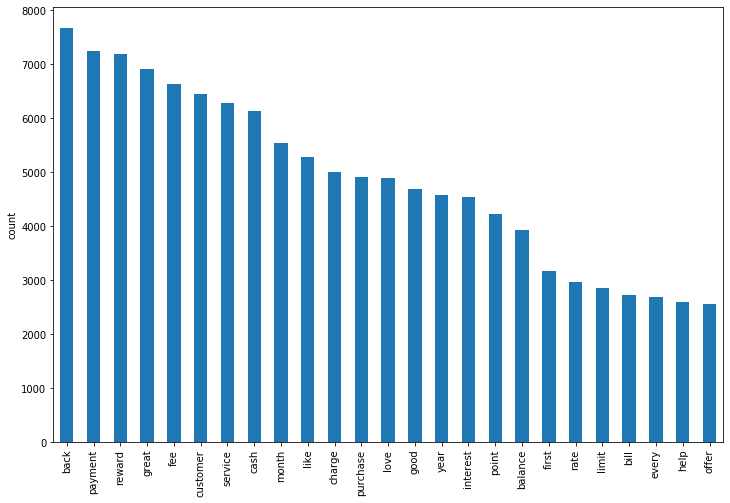

In [16]:
word_count(df.reviews)

## Bigrams and Trigrams

In [17]:
df['bigram_tokens'] = add_bigram(df.tokens)
df['trigram_tokens'] = add_trigram(df.tokens)
df.head()

,reviews,rating,company,tokens,bigram_tokens,trigram_tokens
0,great card! we get cash back for our grocery a...,4.0,American Express Blue Cash Preferred,"[great, cash, back, grocery, gas, purchase, fo...","[great, cash_back, grocery_gas, purchase, food...","[great, cash_back, grocery_gas, purchase, food..."
1,while traveling we had to keep calling the cre...,1.0,Credit One Bank,"[travel, keep, customer, service, lock, transa...","[travel, keep, customer_service, lock, transac...","[travel, keep, customer_service, lock, transac..."
2,great card to have! love all the additional cr...,5.0,Capital One Quicksilver Rewards,"[great, love, additional, rating, check, feature]","[great, love, additional, rating, check, feature]","[great, love, additional, rating, check, feature]"
3,no tengo tanta experiencia asi que no puedo da...,2.0,Citi Double Cash Card,"[tengo, tanta, experiencia, asi, que, puedo, d...","[tengo, tanta, experiencia, asi, que, puedo, d...","[tengo, tanta, experiencia, asi, que, puedo, d..."
4,this is a basic credit card the cash back dea...,4.0,Bank of America Cash Rewards Credit Card,"[basic, cash, back, deal, nice, cash, year, an...","[basic, cash_back, deal, nice, cash, year, ann...","[basic, cash_back, deal, nice, cash, year, ann..."


In [18]:
# Create a dictornary, i.e associate each unique token with unique integer ID
dictionary = corpora.Dictionary(df.trigram_tokens)
print(dictionary)

# Bag of words (document-term matrix)
corpus = [dictionary.doc2bow(text) for text in df.trigram_tokens]
print('Number of documents: %s'%len(corpus))

Dictionary(14427 unique tokens: ['apr_little_high', 'balance_full', 'cash_back', 'food_gas', 'fully']...)
Number of documents: 25708


In [19]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Topic modeling with LDA

In [20]:
model_list, topic_coherence = compute_coherence_lda(corpus, dictionary, start=2, limit=40, step=6)

In [ ]:
# Plot
num_topics = range(2, 40, 6)
plt.plot(num_topics, topic_coherence)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('../figures/topic_coherence.png')

In [22]:
# Print the coherence scores
for top, cv in zip(num_topics, topic_coherence):
    print("{} topics  have coherence score of {}".format(top, round(cv, 4)))

2 topics  have coherence score of 0.2953
8 topics  have coherence score of 0.2888
14 topics  have coherence score of 0.282
20 topics  have coherence score of 0.2805
26 topics  have coherence score of 0.2728
32 topics  have coherence score of 0.2675
38 topics  have coherence score of 0.2646


In [23]:
optimal_lda = model_list[1]

In [24]:
optimal_lda.show_topics(num_topics=11, num_words=10)

[(0,
  '0.012*"customer_service" + 0.010*"issue" + 0.007*"like" + 0.007*"work" + 0.007*"good" + 0.006*"help" + 0.006*"year" + 0.006*"find" + 0.005*"payment" + 0.005*"back"'),
 (1,
  '0.053*"great" + 0.042*"love" + 0.035*"reward" + 0.028*"good" + 0.023*"cash_back" + 0.023*"customer_service" + 0.021*"like" + 0.012*"year" + 0.011*"best" + 0.011*"app"'),
 (2,
  '0.017*"good" + 0.014*"customer_service" + 0.012*"experience" + 0.012*"problem" + 0.012*"like" + 0.010*"website" + 0.010*"customer" + 0.009*"excellent" + 0.009*"service" + 0.009*"thank"'),
 (3,
  '0.029*"payment" + 0.021*"charge" + 0.011*"balance" + 0.011*"close" + 0.010*"paid" + 0.010*"bill" + 0.009*"fee" + 0.009*"cancel" + 0.008*"check" + 0.008*"phone"'),
 (4,
  '0.066*"point" + 0.044*"reward" + 0.039*"travel" + 0.025*"purchase" + 0.021*"earn" + 0.018*"great" + 0.014*"love" + 0.013*"venture" + 0.012*"mile" + 0.010*"bonus"'),
 (5,
  '0.010*"charge" + 0.007*"que" + 0.006*"help" + 0.006*"issue" + 0.006*"back" + 0.005*"many" + 0.005*"

In [25]:
# from wordcloud import WordCloud

In [26]:
# fig, axes = plt.subplots(2,4, figsize=(15,10), sharex=True, sharey=True)
# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topics = optimal_lda.show_topics(num_topics=20, num_words=20, formatted=False)
#     plt.imshow(WordCloud().fit_words(dict(topics[i][1])))
#     plt.axis("off")
#     plt.title("Topic {}".format(i))
# plt.savefig('../figures/fig3.pdf')

In [27]:
import pyLDAvis.gensim

In [28]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_lda, corpus, dictionary,sort_topics=False)

/Users/sowerre/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x  \
topic             
0     -0.089383   
1      0.208280   
2      0.009177   
3     -0.163632   
4      0.188896   
5     -0.155572   
6      0.116611   
7     -0.114377   

              y  \
topic             
0      0.069449   
1      0.042079   
2      0.129747   
3      0.022561   
4     -0.119228   
5      0.014078   
6      0.028166   
7     -0.186852   

       topics  \
topic           
0           1   
1           2   
2           3   
3           4   
4           5   
5           6   
6           7   
7           8   

       cluster  \
topic            
0            1   
1            1   
2            1   
3            1   
4            1   
5            1   
6            1   
7            1   

            Freq  
topic             
0       6.901684  
1      15.074636  
2       7.232833  
3      34.697323  
4       6.972686  
5       5.161470  
6      18.594923  
7       5.364445  , topic_info=    Category  \
249  Default   
95   Default   
5    Default   
28   Default   
23   Default   
..       ...   
650   Topic8   
7     Topic8   
116   Topic8   
70    Topic8   
216   Topic8   

            Freq  \
249  3531.000000   
95   5830.000000   
5    6825.000000   
28   4679.000000   
23   1921.000000   
..           ...   
650    86.074829   
7     103.465141   
116    82.423187   
70     92.953987   
216    83.942062   

        Term  \
249    point   
95    reward   
5      great   
28      love   
23    travel   
..       ...   
650    store   
7      month   
116  thought   
70    charge   
216    offer   

           Total  \
249  3531.000000   
95   5830.000000   
5    6825.000000   
28   4679.000000   
23   1921.000000   
..           ...   
650   591.976135   
7    3610.645508   
116   568.730225   
70   4471.384766   
216  2456.441162   

     loglift  \
249  30.0000   
95   29.0000   
5    28.0000   
28   27.0000   
23   26.0000   
..       ...   
650   0.9971   
7    -0.6270   
116   0.9938   
70   -0.9480   
216  -0.4510   

     logprob  
249  30.0000  
95   29.0000  
5    28.0000  
28   27.0000  
23   26.0000  
..       ...  
650  -5.6965  
7    -5.5125  
116  -5.7399  
70   -5.6196  
216  -5.7216  

[656 rows x 6 columns], token_table=      Topic  \
term          
104       1   
104       2   
104       3   
104       4   
104       5   
...     ...   
50        8   
2005      1   
2005      4   
4421      3   
4182      8   

          Freq  \
term             
104   0.043258   
104   0.091680   
104   0.107821   
104   0.212415   
104   0.107176   
...        ...   
50    0.015790   
2005  0.007828   
2005  0.978464   
4421  0.964236   
4182  0.980923   

                       Term  
term                         
104                    able  
104                    able  
104                    able  
104                    able  
104                    able  
...                     ...  
50                     year  
2005           zero_balance  
2005           zero_balance  
4421          zero_interest  
4182  zero_percent_interest  

[1916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])